In [2]:


def inference_timing():
    model = EfficientNet.from_pretrained('efficientnet-b0')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)

    # initializing
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 300
    timings= np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model(dummy_input)
    # MEASURE PERFORMANCE
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    return mean_syn, std_syn


ModuleNotFoundError: No module named 'datasets'

this is the code which times inference with cuda and also evaluates the asynchronization within the GPU. 
since I do not have access to GPUs right now, I might as well just write the code for CPUs and afterwards time everything for the GPU

blank

now let's experiment within the CPU

running this server on a remote server

In [ ]:
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import time
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

def inference_timing():
    tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
    model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dummy_input = tokenizer("What to do today", return_tensors="pt")
    # initializing
    start_time_cs = time.time()
    repetitions = 5
    timings= np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model.generate(**dummy_input)
    stop_time_cs = time.time()
    cold_start_time = stop_time_cs - start_time_cs
    # MEASURE PERFORMANCE
    with torch.no_grad(): #good for inference measurement
        for rep in range(repetitions):
            start_time_inf = time.time()
            _ = model.generate(**dummy_input)
            stop_time_inf = time.time()
            # WAIT FOR GPU SYNC
            timings[rep] = stop_time_inf - start_time_inf

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    return timings

res = inference_timing()
file = open("file1.txt", "w+")
content = str(res)
file.write(content)
file.close()

file = open("file1.txt", "r")
content = file.read()

print("\nContent in file1.txt:\n", content)
file.close()

reading the file with inference measurements

In [19]:
import pandas as pd

In [28]:
dt = pd.read_csv("data_cpu.csv")
dt

,data,
0,[0.36341786],NaN
1,[0.4667685 ],NaN
2,[0.29130769],NaN
3,[0.29071188],NaN
4,[0.29123354],NaN
...,...,...
995,[0.28732133],NaN
996,[0.28745103],NaN
997,[0.28732276],NaN
998,[0.28720951],NaN


In [32]:
dt['        data'].replace(regex=True, inplace=True, to_replace=r'[^0-9.\-]', value=r'')
dt['        data'] = dt['        data'].astype(float)


In [33]:
dt

,data,
0,0.363418,NaN
1,0.466768,NaN
2,0.291308,NaN
3,0.290712,NaN
4,0.291234,NaN
...,...,...
995,0.287321,NaN
996,0.287451,NaN
997,0.287323,NaN
998,0.287210,NaN


In [37]:
import numpy as np
import statsmodels.distributions.empirical_distribution
from statsmodels.distributions.empirical_distribution import ECDF

let's build an empirical distribution factor

In [40]:
input = np.array(dt['        data'])
ecdf = ECDF(input)
ecdf

In [49]:

# example of a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack

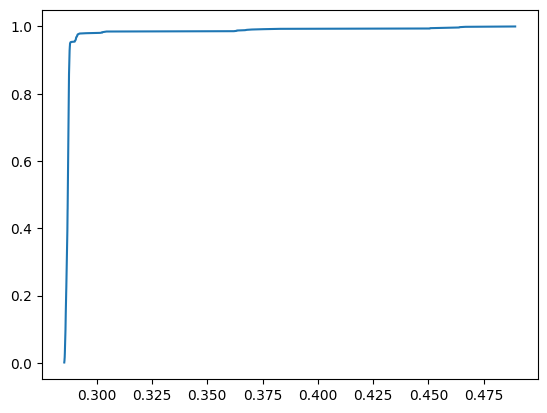

In [50]:
# plot the cdf
pyplot.plot(ecdf.x, ecdf.y)
pyplot.show()
pyplot.title('CDF Graph of inference time')
pyplot.xlabel('Time (ms)')
pyplot.ylabel('Number of inferences')
pyplot.grid()

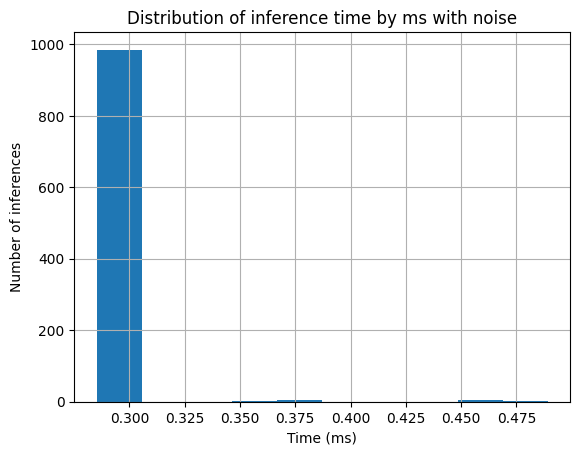

In [58]:
pyplot.hist(input)
pyplot.title('Distribution of inference time by ms with noise')
pyplot.xlabel('Time (ms)')
pyplot.ylabel('Number of inferences')
pyplot.grid()

getting rid of noises

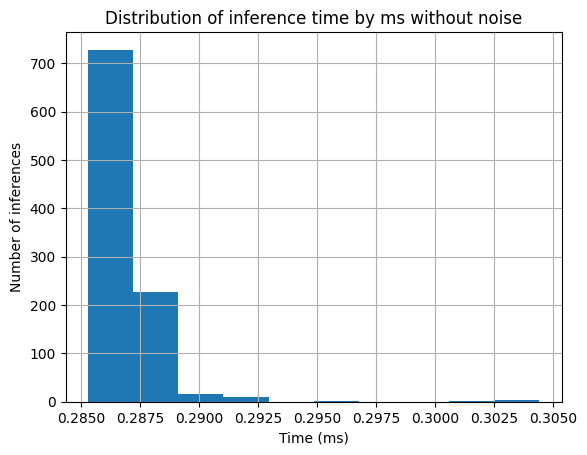

In [57]:
input_without_noise = input[input < 0.325]
pyplot.hist(input_without_noise)
pyplot.title('Distribution of inference time by ms without noise')
pyplot.xlabel('Time (ms)')
pyplot.ylabel('Number of inferences')
pyplot.grid()

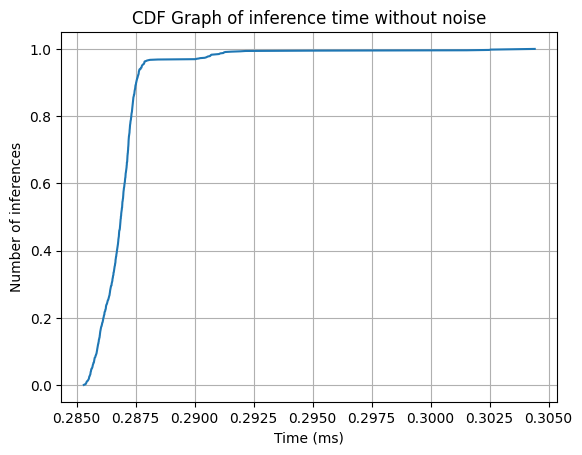

In [61]:
ecdf1 = ECDF(input_without_noise)
pyplot.plot(ecdf1.x, ecdf1.y)
pyplot.title('CDF Graph of inference time without noise')
pyplot.xlabel('Time (ms)')
pyplot.ylabel('Number of inferences')
pyplot.grid()